In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!gdown https://drive.google.com/drive/folders/19JWGJib5Y3PixVbsAf-EpYZZkkFvU6DC?usp=sharing

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://drive.google.com/drive/folders/19JWGJib5Y3PixVbsAf-EpYZZkkFvU6DC?usp=sharing
To: /content/19JWGJib5Y3PixVbsAf-EpYZZkkFvU6DC?usp=sharing
1.64kB [00:00, 4.66MB/s]


In [3]:
import os
#os.chdir("/content/drive/My Drive/Colab Notebooks/Comp432Project/Dataset1/ColorectalCancer_")#100
#os.chdir("/content/drive/My Drive/Colab Notebooks/500 Data/Colorectal Cancer") #500
os.chdir("/content/drive/My Drive/Colab Notebooks/Full Data/Colorectal Cancer") #Full

In [4]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim
from torchvision import datasets, transforms

import os
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import classification_report


print(torch.cuda.is_available())

torch.cuda.empty_cache()

True


In [5]:
def get_data():
    #data_dir = '/content/drive/My Drive/Colab Notebooks/Comp432Project/Dataset1/ColorectalCancer_' #100
    #data_dir = '/content/drive/My Drive/Colab Notebooks/500 Data/Colorectal Cancer' #500
    data_dir = '/content/drive/My Drive/Colab Notebooks/Full Data/Colorectal Cancer' #Full
    transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((224,224))])
    data_set = datasets.ImageFolder(root=data_dir, transform=transform)
    print(data_set.classes)

    n = len(data_set)  # total number of examples
    n_test = int(0.20 * n)  # take ~20% for test
    for x in range(0, 9):  # rounding it to be divisible by 4
        n_test += 1
        if n_test % 4 == 0:
            break
    train_set, test_set = torch.utils.data.random_split(data_set, [n - n_test, n_test])
    print(n_test)

    train = DataLoader(train_set, batch_size=32, shuffle=True)
    test = DataLoader(test_set, batch_size= 10, shuffle=False)


    return train, test


In [6]:

# Defining the Model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolutional layer (conv1)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer (conv2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (if needed)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)

        return out


#
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



In [7]:
#delprev training
torch.cuda.empty_cache()

# Getting the data
train, test= get_data()
# Instanciating the ResNet18 Class created earlier and Assigning it as our model
model = ResNet18(3)

# The loss function
criterion = nn.CrossEntropyLoss()
#
optimizer = optim.Adam(model.parameters(), lr=0.001)
# momentum=0.9

# Using Cuda cores for the training
model=model.to(torch.device("cuda:0"))


['MUS', 'NORM', 'STR']
1204


train
Epoch 1/30, Loss: 0.3846116065979004
Epoch 1/30, Loss: 0.21619436144828796
Epoch 1/30, Loss: 0.5602291822433472
Epoch 1/30, Loss: 0.38866156339645386
Epoch 1/30, Loss: 0.36877480149269104
Epoch 1/30, Loss: 0.47496455907821655
Epoch 1/30, Loss: 0.44944238662719727
Epoch 1/30, Loss: 0.5220180749893188
Epoch 1/30, Loss: 0.3065364956855774
Epoch 1/30, Loss: 0.6044745445251465
Epoch 1/30, Loss: 0.2230580598115921
Epoch 1/30, Loss: 0.3683241009712219
Epoch 1/30, Loss: 0.7906428575515747
Epoch 1/30, Loss: 0.3792285919189453
Epoch 1/30, Loss: 0.5937207937240601
Epoch 1/30, Loss: 0.4790107309818268
Epoch 1/30, Loss: 0.5705828666687012
Epoch 1/30, Loss: 0.24934011697769165
Epoch 1/30, Loss: 0.24311476945877075
Epoch 1/30, Loss: 0.3563036620616913
Epoch 1/30, Loss: 0.29309922456741333
Epoch 1/30, Loss: 0.6491250991821289
Epoch 1/30, Loss: 0.7043219804763794
Epoch 1/30, Loss: 0.47080719470977783
Epoch 1/30, Loss: 0.3427312672138214
Epoch 1/30, Loss: 0.7061482667922974
Epoch 1/30, Loss: 0.228

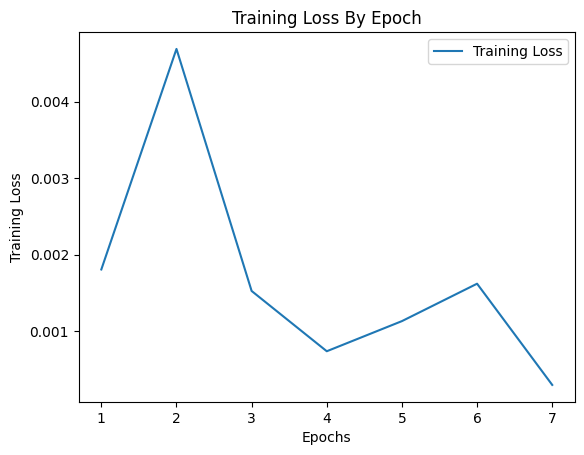

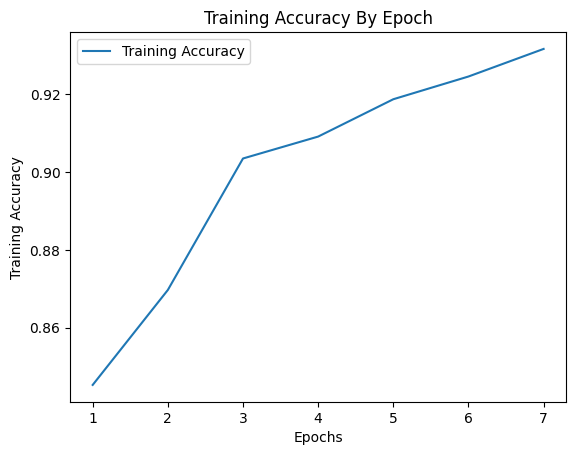

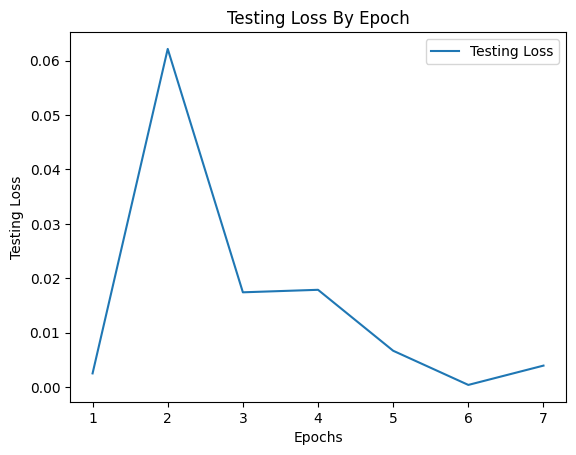

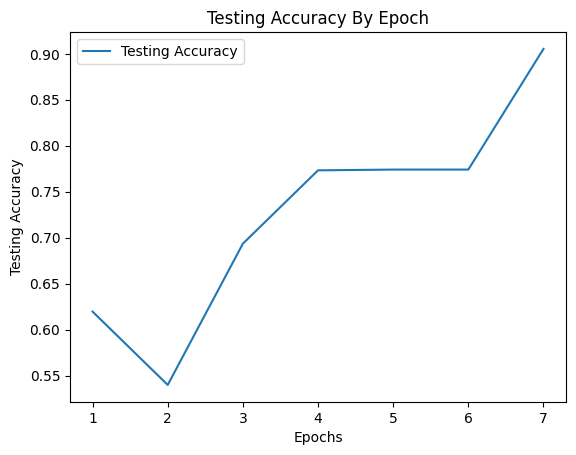

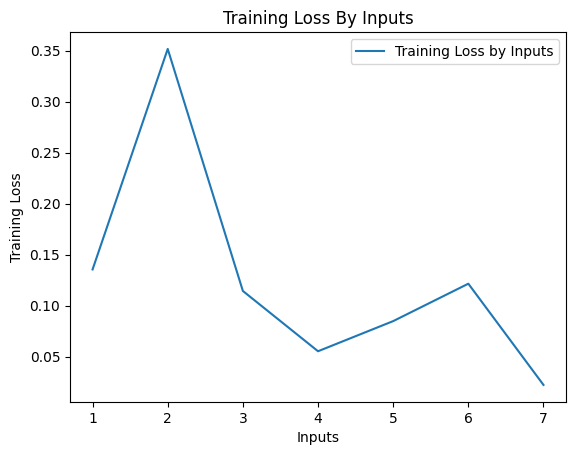

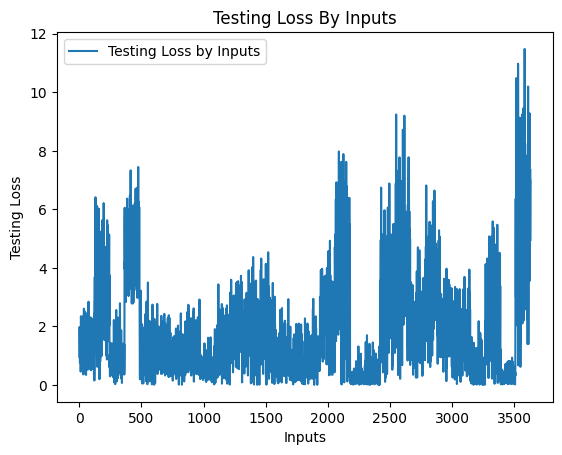

In [9]:
# Training
num_epoch=30
num_epoch_saved=0
lr=0.001
test_size=0
do_save=False

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

running_train_losses = []
running_test_losses = []

#For Saving the model
#'/content/drive/My Drive/Colab Notebooks/Saved models/Latest save'
model_name_to_save = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Saved models/Latest save/{model_name_to_save}"
save_dir_opti=F"/content/drive/My Drive/Colab Notebooks/Saved models/Latest save/optimizer.pth"

print("train")
for epoch in range(num_epoch):
    model.train()
    loss_train= 0.0
    correct = 0
    total = 0
    test_size=0

    if epoch>=1:
      state_dict = torch.load(save_dir)
      state_dict_opti = torch.load(save_dir_opti)
      model.load_state_dict(state_dict)
      optimizer.load_state_dict(state_dict_opti)


    for inputs, labels in train:
      #To Cuda
      inputs=inputs.to(torch.device("cuda:0"))
      labels=labels.to(torch.device("cuda:0"))

      optimizer.zero_grad()
      outputs = model(inputs)
      loss_train = criterion(outputs, labels)
      loss_train.backward()
      optimizer.step()

      #Loss by input Train
      loss_by_input=loss_train.item()
      loss_train += loss_train.item()
      print(f"Epoch {epoch+1}/{num_epoch}, Loss: {loss_by_input}")

      #Accuracy
      total += labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()


    # Checking if the loss has improved this epoch. If so it will save that model,
    # otherwise it will just reload the previous  model and continue from there.
    loss_by_epoch=loss_train / len(train)
    print("This epoch:")
    #print(loss_by_epoch.detach().numpy())
    print(loss_by_epoch.detach().cpu().numpy())


    #**************
    #Test
    model.eval()
    loss_test = 0.0
    correct2 = 0
    total2 = 0
    with torch.no_grad():
      for inputs, labels in test:
        #To Cuda
        inputs=inputs.to(torch.device("cuda:0"))
        labels=labels.to(torch.device("cuda:0"))

        outputs = model(inputs)

        test_size+=1

        #Loss Test
        loss_test = criterion(outputs, labels)
        loss_by_input_test=loss_test.item()#New
        loss_test += loss_test.item()

        running_test_losses.append(loss_by_input_test)#New

        #Accuracy Test
        total2 += labels.size(0)
        _, predicted2 = torch.max(outputs.data, 1)
        correct2 += (predicted2 == labels).sum().item()

      loss_by_epoch2=loss_test / len(test)
      #test_losses.append(loss_by_epoch2.detach().numpy())

      accuracy2 = correct2 / total2
      if (epoch<=2 or (accuracy2 >= test_accuracy[-1])):
        test_losses.append(loss_by_epoch2.detach().cpu().numpy())
        test_accuracy.append(accuracy2)
        do_save=True
        print("Saved based on test accuracy")


    #**********

    #epoch<=1
    if (do_save):
     #(loss_by_epoch.detach().numpy() <= train_losses[-1])):
      num_epoch_saved=num_epoch_saved+1
      #Save model
      torch.save(model.state_dict(), save_dir)
      torch.save(optimizer.state_dict(), save_dir_opti)
      print('saved')
      #Loss by batch Train
      #train_losses.append(loss_by_epoch.detach().numpy())
      train_losses.append(loss_by_epoch.detach().cpu().numpy())

      running_train_losses.append(loss_by_input) #New

      #Accuracy by batch Train
      accuracy = correct / total
      train_accuracy.append(accuracy)
      print(f"Epoch {epoch+1}/{num_epoch}, Accuracy: {accuracy}")
      do_save=False


print(num_epoch)
print(len(train_losses))
print(len(test_losses))


#Save model
#torch.save(model.state_dict(), save_dir)
#print('saved')

#del model
torch.cuda.empty_cache()

# Plot Loss Train
plt.plot(range(1, num_epoch_saved+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss By Epoch')
plt.legend()
plt.show()


# Plot Accuracy Train
plt.plot(range(1, num_epoch_saved+1), train_accuracy , label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy By Epoch')
plt.legend()
plt.show()

# Plot Loss Test
plt.plot(range(1, num_epoch_saved+1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Testing Loss')
plt.title('Testing Loss By Epoch')
plt.legend()
plt.show()

# Plot Accuracy Test
plt.plot(range(1, num_epoch_saved+1), test_accuracy , label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy By Epoch')
plt.legend()
plt.show()


#By input
plt.plot(range(1, len(running_train_losses)+1), running_train_losses, label='Training Loss by Inputs')
plt.xlabel('Inputs')
plt.ylabel('Training Loss')
plt.title('Training Loss By Inputs')
plt.legend()
plt.show()

plt.plot(range(1, len(running_test_losses)+1), running_test_losses, label='Testing Loss by Inputs')
plt.xlabel('Inputs')
plt.ylabel('Testing Loss')
plt.title('Testing Loss By Inputs')
plt.legend()
plt.show()


Test
end loop
10
end loop
20
end loop
30
end loop
40
end loop
50
end loop
60
end loop
70
end loop
80
end loop
90
end loop
100
end loop
110
end loop
120
end


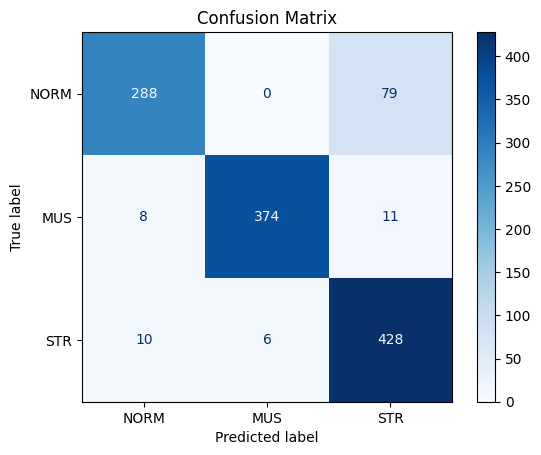

On Testing Data
              precision    recall  f1-score   support

        NORM       0.94      0.78      0.86       367
         MUS       0.98      0.95      0.97       393
         STR       0.83      0.96      0.89       444

    accuracy                           0.91      1204
   macro avg       0.92      0.90      0.90      1204
weighted avg       0.91      0.91      0.90      1204



In [10]:
#Test
#Load model
model_name_to_load = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Saved models/Latest save/{model_name_to_load}"

state_dict = torch.load(save_dir)
model.load_state_dict(state_dict)
model=model.to(torch.device("cuda:0"))

print('Test')
labels_array = []
predictions = []

model.eval()
count=0
with torch.no_grad():
  for inputs, labels in test:
    inputs=inputs.to(torch.device("cuda:0"))
    labels=labels.to(torch.device("cuda:0"))

    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    labels_array.extend(labels.cpu().numpy())
    predictions.extend(predicted.cpu().numpy())

    count=count+1
    if (count % 10)==0:
      print('end loop')
      print(count)

    #labels.extend(labels.cuda().numpy())
    #predictions.extend(predicted.cuda().numpy())
print("end")

# Confusion matrix
c_matrix = confusion_matrix(labels_array, predictions, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(c_matrix, display_labels=['NORM', 'MUS', 'STR'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

#Classification report
print("On Testing Data")
print(classification_report(labels_array, predictions, target_names=['NORM', 'MUS', 'STR']))




In [ ]:
#Classification Report on training data
#Load model
model_name_to_load = 'model.pth'
save_dir=F"/content/drive/My Drive/Colab Notebooks/Saved models/Latest save/{model_name_to_load}"

state_dict = torch.load(save_dir)
model.load_state_dict(state_dict)
model=model.to(torch.device("cuda:0"))

with torch.no_grad():
  for inputs, labels in train:
    inputs=inputs.to(torch.device("cuda:0"))
    labels=labels.to(torch.device("cuda:0"))

    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    labels_array.extend(labels.cpu().numpy())
    predictions.extend(predicted.cpu().numpy())

    #labels.extend(labels.cuda().numpy())
    #predictions.extend(predicted.cuda().numpy())
print("end")
#Classification report
print("On Training Data")
print(classification_report(labels_array, predictions, target_names=['NORM', 'MUS', 'STR']))

KeyboardInterrupt: ignored